In [4]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import re
import nltk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
# nltk.download('punkt')
import numpy as np
from copy import deepcopy
import seaborn as sns

In [ ]:
df = pd.read_csv("news.csv")
df.head(2)

,Class Index,Title,Description
0,2,Iowa Expecting Capital One Invitation (AP),AP - Here's some advice from the Capital One B...
1,1,106 mainland enterprises listed outside mainla...,"By the end of August 2004, a total of 106 Chin..."


In [ ]:
X = df["Title"]
y = df["Class Index"]

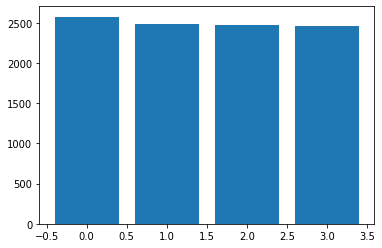

In [ ]:
#Сбалансирована
plt.bar(x=range(4), height=y.value_counts());

In [ ]:
# nltk.download('punkt')
from string import punctuation
pattern = re.compile(r"[a-zA-Z]+")

def to_words(text):
    text = text.lower()
    words = [pattern.search(word).group() for word in word_tokenize(text) if word not in punctuation and pattern.search(word)]
    return words

In [ ]:
for i in range(X.shape[0]):
    X[i] = to_words(X[i])

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
class Vocab:
    def __init__(self, data):
        self.max_seq_len = data.apply(len).max()
        tokens = set()
        for item in data:
            tokens.update(item)

        self.idx_to_token = dict(enumerate(tokens, 1))
        self.idx_to_token[0] = "<PAD>"
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = torch.LongTensor(y)
        self.vocab = vocab

    def vectorize(self, text):
        sent_t = torch.zeros(self.vocab.max_seq_len).long()
        for i, token in enumerate(text):
            sent_t[i] = self.vocab.token_to_idx[token]
        return sent_t

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X.iloc[idx]), self.y[idx]

In [ ]:
batch_size = 64
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
vocab = Vocab(X)
trainset = TextDataset(X_train, y_train, vocab)
testset = TextDataset(X_test, y_test, vocab)
trainloader = DataLoader(trainset, batch_size=batch_size)
testloader = DataLoader(testset, batch_size=batch_size)

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_len, pad_idx, num_classes):
        super(MyModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.emb = nn.Embedding(
            num_embeddings=vocab_len,
            embedding_dim=input_size,
            padding_idx=pad_idx
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        x = self.emb(x)
        output, _ = self.lstm(x)
        x = self.fc(output[:,-1,:])
        return x

In [ ]:
model = MyModel(
    input_size=64,
    hidden_size=64,
    vocab_len=vocab.vocab_len,
    pad_idx=0,
    num_classes=4
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
n_epochs = 11
epoch_step = 2
res = np.zeros((4, n_epochs))

for epoch in range(n_epochs):
    y_pred = torch.empty(0)
    y_true = torch.empty(0, dtype=torch.long)
    model.train()
    for X_batch, y_batch in trainloader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_true = torch.cat((y_true, y_batch))
            y_pred = torch.cat((y_pred, predictions))
    with torch.no_grad():
        train_acc = accuracy_score(y_true, y_pred.argmax(dim=1)).item()
        train_loss = criterion(y_pred, y_true).item()

    model.eval()
    with torch.no_grad():
        y_pred = torch.empty(0)
        y_true = torch.empty(0, dtype=torch.long)
        for X_batch, y_batch in testloader:
            predictions = model(X_batch)
            y_true = torch.cat((y_true, y_batch))
            y_pred = torch.cat((y_pred, predictions))
        val_acc = accuracy_score(y_true, y_pred.argmax(dim=1)).item()
        val_loss = criterion(y_pred, y_true).item()

        if epoch % epoch_step == 0:
            print(f'#{epoch} train loss: {train_loss:6.4f} train acc:\
 {train_acc:6.4f} test loss: {val_loss:6.4f} test acc: {val_acc:6.4f}')
    res[:, epoch] = train_loss, train_acc, val_loss, val_acc

#0 train loss: 1.3734 train acc: 0.2731 test loss: 1.2812 test acc: 0.3665
#2 train loss: 0.9307 train acc: 0.5455 test loss: 1.0216 test acc: 0.5560
#4 train loss: 0.4051 train acc: 0.8595 test loss: 0.9734 test acc: 0.6895
#6 train loss: 0.1827 train acc: 0.9465 test loss: 1.0424 test acc: 0.6955
#8 train loss: 0.1023 train acc: 0.9714 test loss: 1.3431 test acc: 0.6985
#10 train loss: 0.0944 train acc: 0.9734 test loss: 1.4237 test acc: 0.6800


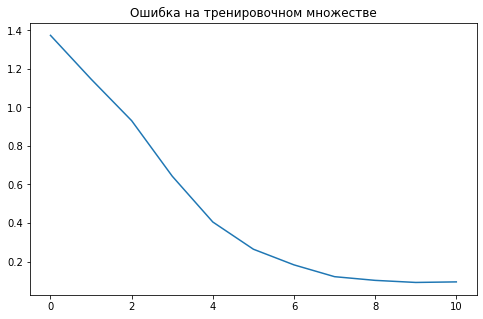

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Ошибка на тренировочном множестве")
plt.plot(range(n_epochs), res[0]);

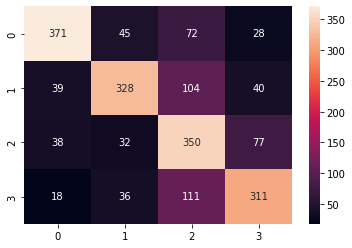

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred.argmax(dim=1)), annot=True, fmt="2d");

In [ ]:
print(classification_report(y_true, y_pred.argmax(dim=1)))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       516
           1       0.74      0.64      0.69       511
           2       0.55      0.70      0.62       497
           3       0.68      0.65      0.67       476

    accuracy                           0.68      2000
   macro avg       0.69      0.68      0.68      2000
weighted avg       0.69      0.68      0.68      2000



поиск экстремума

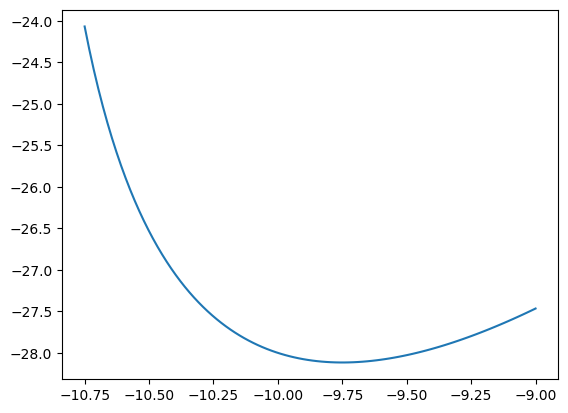

In [5]:
def function(x):
    return 4*x - 5*torch.log(x+11)+12
array_x = torch.linspace(-10.75, -9, 100)
array_y = []
for x in array_x:
    array_y.append(function(x))
plt.plot(array_x, array_y);

x min = -9.75 при y min = -28.12


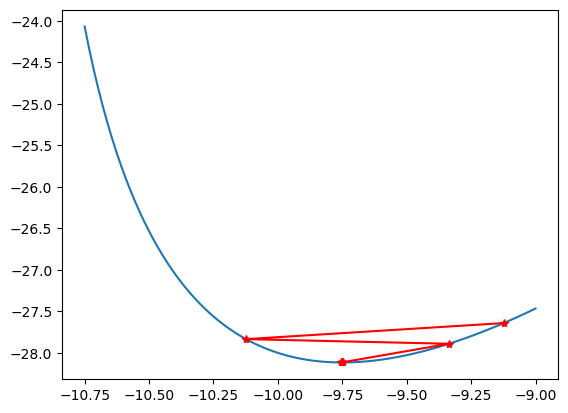

In [7]:
list_x, list_y = [], []
current_x = random.sample(list(array_x[~np.isnan(array_x)]), 1)
current_x = torch.tensor(current_x, requires_grad=True)
e = 0.0001
prev = 10000
optimizer = optim.Adagrad((current_x, ), lr=1)
while abs(prev-current_x) > e:
    prev = current_x.item()
    current_y = function(current_x)
    list_x.append(current_x.item())
    list_y.append(current_y.item())
    current_y.backward()
    optimizer.step()
    optimizer.zero_grad()

print(f"x min = {list_x[-1]:.2f} при y min = {list_y[-1]:.2f}")
plt.plot(array_x, array_y)
plt.plot(list_x, list_y, c="red", marker="*");